Started (in earnest) on May 27, 2021 at 1:30 PM CT.

Based on tutorial [here](https://github.com/radio-astro-tools/tutorials/blob/d4e42de5150387252a5549f325423f374895fa99/masking_and_moments/masking_and_moments_guide.ipynb) by Eric Koch, Adam Ginsburg, Tom Robitaille, and Erik Rosolowsky.

In [266]:
# Import statements
%matplotlib inline
# %matplotlib widget

import os
from pathlib import Path
from time import time
import warnings
# warnings.simplefilter('ignore')

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-colorblind')

import astropy.units as u
from astropy.io import fits
# from astropy.visualization import quantity_support
# quantity_support()

from spectral_cube import SpectralCube
# from spectral_cube.dask_spectral_cube import DaskSpectralCube

from astroquery.splatalogue import Splatalogue

# plt.rcParams['image.origin'] = 'lower'
# plt.gca().set_xticks([]); plt.gca().set_yticks([])
from pylab import imshow

import time

import scipy.ndimage as nd

# Uncomment to create a progress bar for all dask operations.
# Disabled here as it increases the run time significantly for this small cube.
# from dask.diagnostics import ProgressBar
# pbar = ProgressBar()
# pbar.register()

In [267]:
# Load in cubes
results = '/blue/adamginsburg/abulatek/brick/symlinks/imaging_results/'

fn_87_spw25 = results+'source_ab_87_spw25_clean_2sigma_n50000_masked_3sigma_pbmask0p18.image'
fn_102_spw106 = results+'source_ab_102_spw106_clean_2sigma_n50000_masked_3sigma_pbmask0p18.image'
fn_95_spw25 = results+'source_ab_95_spw25_clean_2sigma_n50000_masked_3sigma_pbmask0p18.image'

cube_87_spw25 = SpectralCube.read(fn_87_spw25, format='casa_image', use_dask=True) 
cube_102_spw106 = SpectralCube.read(fn_102_spw106, format='casa_image', use_dask=True) 
cube_95_spw25 = SpectralCube.read(fn_95_spw25, format='casa_image', use_dask=True)

/blue/adamginsburg/abulatek/anaconda/lib/python3.7/site-packages/casa_formats_io-0.1-py3.7-linux-x86_64.egg/casa_formats_io/casa_dask.py:232: RuntimeWarning: divide by zero encountered in long_scalars
  factors = [f for f in range(stacks[dim] + 1) if stacks[dim] % f == 0]
/blue/adamginsburg/abulatek/anaconda/lib/python3.7/site-packages/casa_formats_io-0.1-py3.7-linux-x86_64.egg/casa_formats_io/casa_dask.py:232: RuntimeWarning: divide by zero encountered in long_scalars
  factors = [f for f in range(stacks[dim] + 1) if stacks[dim] % f == 0]
/blue/adamginsburg/abulatek/anaconda/lib/python3.7/site-packages/casa_formats_io-0.1-py3.7-linux-x86_64.egg/casa_formats_io/casa_dask.py:232: RuntimeWarning: divide by zero encountered in long_scalars
  factors = [f for f in range(stacks[dim] + 1) if stacks[dim] % f == 0]


In [268]:
def get_line(cube, chemical_name, freq_lo, freq_hi, vel):
    tbl = Splatalogue.query_lines(freq_lo-0.1*u.GHz, freq_hi+0.1*u.GHz, 
                                  chemical_name=chemical_name,
                                  energy_max=500, # more lines w/ max energy > 140
                                  energy_type='eu_k',
                                  line_lists=['JPL'],
                                  show_upper_degeneracy=True, 
                                  show_qn_code=True)
    line_freqs = tbl['Meas Freq-GHz(rest frame,redshifted)'].data
    shifted_line_freqs = line_freqs-((vel/299792)*line_freqs) # Shift by velocity
    tbl['Shifted Freq-GHz'] = shifted_line_freqs
    return tbl

def get_subcube(cube, center_freq, slab_width):
    print(center_freq)
    subcube = cube.spectral_slab(center_freq - 0.1*u.GHz, center_freq + 0.1*u.GHz).to(u.K)
    subcube_v = subcube.with_spectral_unit(u.km/u.s, 
                                           rest_value = center_freq,
                                           velocity_convention = 'radio').spectral_slab(-slab_width,
                                                                                        slab_width)
    print(subcube_v)
    return subcube_v

def get_noise_map(cube_noise):
#     mad_std_spectrum = cube_noise.mad_std(axis=(1, 2))
#     plt.plot(mad_std_spectrum.spectral_axis.value, mad_std_spectrum.value, drawstyle='steps-mid')
#     plt.xlabel('Velocity (km/s)')
#     plt.ylabel(r' Noise standard deviation $\sigma$ (K)')
#     plt.ylim([0., 0.30]) # Best to extend the range to 0.
#     plt.axhline(0.25, linestyle='--', color='k', linewidth=3, label='A priori noise expectation')
#     plt.legend(frameon=True)
    cube_sclip = cube_noise.sigma_clip_spectrally(3) # Clip values above 3-sigma 
#     mad_std_spectrum_sclip = cube_sclip.mad_std(axis=(1, 2))
#     plt.plot(mad_std_spectrum_sclip.spectral_axis.value, mad_std_spectrum_sclip.value, drawstyle='steps-mid')
#     plt.xlabel('Velocity (km/s)')
#     plt.ylabel(r' Noise standard deviation $\sigma$ (K)')
#     plt.ylim([0., 0.30]) # Best to extend the range to 0.
#     plt.axhline(0.25, linestyle='--', color='k', linewidth=3, label='A priori noise expectation')
#     plt.legend(frameon=True)
    mad_std_map_sclip = cube_sclip.mad_std(axis=0) # Calculate sigma along the spectral dimension
#     imshow(mad_std_map_sclip.value, cmap='gray', origin='lower')
    return mad_std_map_sclip
    
def get_signal_mask_scipy(cube_signal, mad_std_map_sclip):
    # Make a low and high mask
    low_snr_mask = (cube_signal > 3 * mad_std_map_sclip).include()
    high_snr_mask = (cube_signal > 10 * mad_std_map_sclip).include()
    low_snr_mask = low_snr_mask.compute() # We need to convert from a dask array to a numpy array.
    high_snr_mask = high_snr_mask.compute()
    # Find connected structures
    structure = np.ones((3, 3, 3), dtype=bool)
    low_snr_mask_labels, num_labels = nd.label(low_snr_mask, structure=structure)
    print(f"Initial number of regions found: {num_labels}")
    # From the labels, count the number of pixels within each label.
    num_pixels_in_high_snr_mask = nd.sum(high_snr_mask,
                                         labels=low_snr_mask_labels,
                                         index=range(1, num_labels + 1)) # +1 offset for mask labels
    # Repeat for the high signal mask.
    num_pixels_in_low_snr_mask = nd.sum(low_snr_mask,
                                        labels=low_snr_mask_labels,
                                        index=range(1, num_labels + 1)) # +1 offset for mask labels
    # To preserve the low_snr_mask, we will create a new signal mask where we will remove 
    # regions that do not pass the criteria.
    signal_mask = low_snr_mask
    low_min_pixels = 40
    high_min_pixels = 10
    for num, (high_pix_num, low_pix_num) in enumerate(zip(num_pixels_in_high_snr_mask, num_pixels_in_low_snr_mask)):
        if high_pix_num >= high_min_pixels and low_pix_num >= low_min_pixels:
            # This region passes the criteria. Keep it in the mask.
            continue
        # Remove regions that do not pass the criteria.
        # NOTE: enumerate will start with 0, but the mask labels start at 1
        # We apply a +1 offset to `num` to account for this.
        signal_mask[low_snr_mask_labels == num + 1] = False
    signal_mask_labels, num_labels = nd.label(signal_mask,
                                              structure=structure)
    print(f"Final number of regions found: {num_labels}")
    signal_mask = nd.binary_dilation(signal_mask, structure=structure, iterations=1)
    return signal_mask

# def find_outliers():

# def remove_outliers():
    
# def get_moments(subcube_v):
# #     moment_0 = subcube_v.moment0()
# #     moment_1 = subcube_v.moment1()
# #     moment_2 = subcube_v.moment2()
# #     sigma_map = subcube_v.linewidth_sigma()  
# #     fwhm_map = subcube_v.linewidth_fwhm()  
# #     return moment_0, moment_1, moment_2, sigma_map, fwhm_map


### H13CN

In [269]:
# tbl = get_line(cube_87_spw25, ' H13CN ', 86.3*u.GHz, 86.36*u.GHz, 9.5)
# tbl.show_in_notebook()

In [270]:
# center_freq = tbl['Shifted Freq-GHz'][-1]*u.GHz
# cube_5 = get_subcube(cube_87_spw25, center_freq, 5.*u.km/u.s)
# cube_30 = get_subcube(cube_87_spw25, center_freq, 30.*u.km/u.s)
# cube_100 = get_subcube(cube_87_spw25, center_freq, 100.*u.km/u.s)

In [271]:
# # Signal identification and noise estimation
# peak_intensity_5 = cube_5.max(axis=0) # Take the maximum along the spectral dimension

# # Quick vizualization
# imshow(peak_intensity_5.value, cmap='gray')

In [272]:
# # Signal identification and noise estimation
# peak_intensity_30 = cube_30.max(axis=0) # Take the maximum along the spectral dimension

# # Quick vizualization
# imshow(peak_intensity_30.value, cmap='gray')

In [273]:
# # Signal identification and noise estimation
# peak_intensity_100 = cube_100.max(axis=0) # Take the maximum along the spectral dimension

# # Quick vizualization
# imshow(peak_intensity_100.value, cmap='gray')

In [274]:
# mad_std_spectrum_5 = cube_5.mad_std(axis=(1, 2))

# plt.plot(mad_std_spectrum_5.spectral_axis.value, mad_std_spectrum_5.value, drawstyle='steps-mid')
# plt.xlabel('Velocity (km/s)')
# plt.ylabel(r' Noise standard deviation $\sigma$ (K)')

# # Best to extend the range to 0.
# plt.ylim([0., 0.30])

# plt.axhline(0.25, linestyle='--', color='k', linewidth=3, label='A priori noise expectation')
# plt.legend(frameon=True)

In [275]:
# mad_std_spectrum_30 = cube_30.mad_std(axis=(1, 2))

# plt.plot(mad_std_spectrum_30.spectral_axis.value, mad_std_spectrum_30.value, drawstyle='steps-mid')
# plt.xlabel('Velocity (km/s)')
# plt.ylabel(r' Noise standard deviation $\sigma$ (K)')

# # Best to extend the range to 0.
# plt.ylim([0., 0.30])

# plt.axhline(0.25, linestyle='--', color='k', linewidth=3, label='A priori noise expectation')
# plt.legend(frameon=True)

In [276]:
# mad_std_spectrum_100 = cube_100.mad_std(axis=(1, 2))

# plt.plot(mad_std_spectrum_100.spectral_axis.value, mad_std_spectrum_100.value, drawstyle='steps-mid')
# plt.xlabel('Velocity (km/s)')
# plt.ylabel(r' Noise standard deviation $\sigma$ (K)')

# # Best to extend the range to 0.
# plt.ylim([0., 0.30])

# plt.axhline(0.25, linestyle='--', color='k', linewidth=3, label='A priori noise expectation')
# plt.legend(frameon=True)

In [277]:
# cube_sclip_5 = cube_5.sigma_clip_spectrally(3) # Clip values above 3-sigma

# mad_std_spectrum_sclip_5 = cube_sclip_5.mad_std(axis=(1, 2))

# plt.plot(mad_std_spectrum_sclip_5.spectral_axis.value, mad_std_spectrum_sclip_5.value, drawstyle='steps-mid')
# plt.xlabel('Velocity (km/s)')
# plt.ylabel(r' Noise standard deviation $\sigma$ (K)')

# # Best to extend the range to 0.
# plt.ylim([0., 0.30])

# plt.axhline(0.25, linestyle='--', color='k', linewidth=3, label='A priori noise expectation')
# plt.legend(frameon=True)

In [278]:
# cube_sclip_30 = cube_30.sigma_clip_spectrally(3) # Clip values above 3-sigma

# mad_std_spectrum_sclip_30 = cube_sclip_30.mad_std(axis=(1, 2))

# plt.plot(mad_std_spectrum_sclip_30.spectral_axis.value, mad_std_spectrum_sclip_30.value, drawstyle='steps-mid')
# plt.xlabel('Velocity (km/s)')
# plt.ylabel(r' Noise standard deviation $\sigma$ (K)')

# # Best to extend the range to 0.
# plt.ylim([0., 0.30])

# plt.axhline(0.25, linestyle='--', color='k', linewidth=3, label='A priori noise expectation')
# plt.legend(frameon=True)

In [279]:
# cube_sclip_100 = cube_100.sigma_clip_spectrally(3) # Clip values above 3-sigma

# mad_std_spectrum_sclip_100 = cube_sclip_100.mad_std(axis=(1, 2))

# plt.plot(mad_std_spectrum_sclip_100.spectral_axis.value, mad_std_spectrum_sclip_100.value, drawstyle='steps-mid')
# plt.xlabel('Velocity (km/s)')
# plt.ylabel(r' Noise standard deviation $\sigma$ (K)')

# # Best to extend the range to 0.
# plt.ylim([0., 0.30])

# plt.axhline(0.25, linestyle='--', color='k', linewidth=3, label='A priori noise expectation')
# plt.legend(frameon=True)

In [280]:
# mad_std_map_sclip_5 = cube_sclip_5.mad_std(axis=0) # Calculate sigma along the spectral dimension

# imshow(mad_std_map_sclip_5.value, cmap='gray')

In [281]:
# mad_std_map_sclip_30 = cube_sclip_30.mad_std(axis=0) # Calculate sigma along the spectral dimension

# imshow(mad_std_map_sclip_30.value, cmap='gray')

In [282]:
# mad_std_map_sclip_100 = cube_sclip_100.mad_std(axis=0) # Calculate sigma along the spectral dimension

# imshow(mad_std_map_sclip_100.value, cmap='gray')

### H2CS

#### Trying something: estimate noise using part of spectrum without signal

In [283]:
center_freq = 102.924253*u.GHz
cube = get_subcube(cube_102_spw106, center_freq, 15.*u.km/u.s)

102.924253 GHz


DaskVaryingResolutionSpectralCube with shape=(11, 512, 512) and unit=K and chunk size (11, 256, 256):
 n_x:    512  type_x: RA---SIN  unit_x: deg    range:   266.528130 deg:  266.560501 deg
 n_y:    512  type_y: DEC--SIN  unit_y: deg    range:   -28.719152 deg:  -28.690763 deg
 n_s:     11  type_s: VRAD      unit_s: km / s  range:      -14.221 km / s:      14.220 km / s


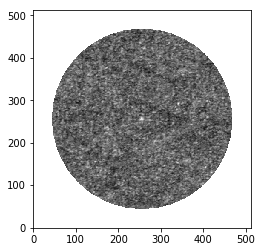

In [284]:
# Signal identification and noise estimation
peak_intensity = cube.max(axis=0) # Take the maximum along the spectral dimension

# Quick vizualization
imshow(peak_intensity.value, cmap='gray', origin='lower')

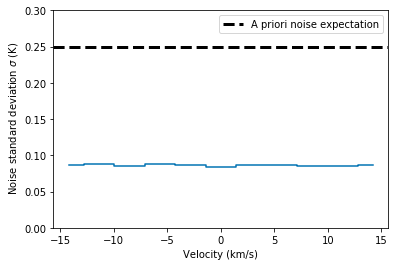

In [285]:
mad_std_spectrum = cube.mad_std(axis=(1, 2))

plt.plot(mad_std_spectrum.spectral_axis.value, mad_std_spectrum.value, drawstyle='steps-mid')
plt.xlabel('Velocity (km/s)')
plt.ylabel(r' Noise standard deviation $\sigma$ (K)')

# Best to extend the range to 0.
plt.ylim([0., 0.30])

plt.axhline(0.25, linestyle='--', color='k', linewidth=3, label='A priori noise expectation')
plt.legend(frameon=True)

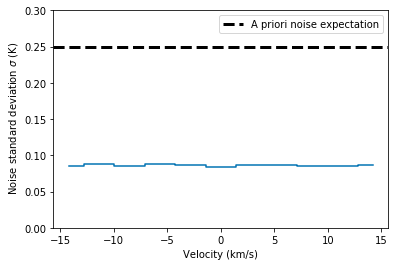

In [286]:
cube_sclip = cube.sigma_clip_spectrally(3) # Clip values above 3-sigma

mad_std_spectrum_sclip = cube_sclip.mad_std(axis=(1, 2))

plt.plot(mad_std_spectrum_sclip.spectral_axis.value, mad_std_spectrum_sclip.value, drawstyle='steps-mid')
plt.xlabel('Velocity (km/s)')
plt.ylabel(r' Noise standard deviation $\sigma$ (K)')

# Best to extend the range to 0.
plt.ylim([0., 0.30])

plt.axhline(0.25, linestyle='--', color='k', linewidth=3, label='A priori noise expectation')
plt.legend(frameon=True)

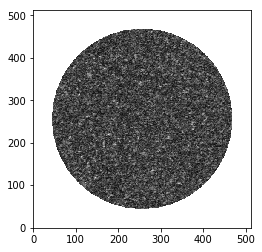

In [287]:
mad_std_map_sclip = cube_sclip.mad_std(axis=0) # Calculate sigma along the spectral dimension

imshow(mad_std_map_sclip.value, cmap='gray', origin='lower')

#### Now, use the noise map on the H2CS cube

In [288]:
tbl = get_line(cube_102_spw106, 'H2CS', 103*u.GHz, 103.07*u.GHz, 41.)
tbl.show_in_notebook()

idx,Species,Chemical Name,"Freq-GHz(rest frame,redshifted)","Freq Err(rest frame,redshifted)","Meas Freq-GHz(rest frame,redshifted)","Meas Freq Err(rest frame,redshifted)",Resolved QNs,CDMS/JPL Intensity,S<sub>ij</sub>&#956;<sup>2</sup> (D<sup>2</sup>),S<sub>ij</sub>,Log<sub>10</sub> (A<sub>ij</sub>),Lovas/AST Intensity,E_L (cm^-1),E_L (K),E_U (cm^-1),E_U (K),Upper State Degeneracy,Quantum Number Code,Linelist,Shifted Freq-GHz
0,H2CS,Thioformaldehyde,--,--,103.03999,0.0001,"3(2,2)-2(2,1)",-4.3594,4.52097,1.663,-5.08492,0.2,40.0668,57.64686,43.50384,62.59197,7.0,303,JPL,103.02589809764771
1,H2CS,Thioformaldehyde,--,--,103.04022,0.00015,"3(0,3)-2(0,2)",-4.0278,8.13836,2.993,-4.82961,0.2,3.4374,4.94562,6.87445,9.89075,7.0,303,JPL,103.02612806619257
2,H2CS,Thioformaldehyde,--,--,103.05181,0.00028,"3(2,1)-2(2,0)",-4.3593,4.52098,1.663,-5.08476,0.13,40.0669,57.647,43.50434,62.59268,7.0,303,JPL,103.03771648112692


In [289]:
center_freq = tbl['Shifted Freq-GHz'][-1]*u.GHz # I am not sure if this is the correct line
cube_signal = get_subcube(cube_102_spw106, center_freq, 15.*u.km/u.s)
cube_signal.beams

103.03771648112692 GHz


DaskVaryingResolutionSpectralCube with shape=(11, 512, 512) and unit=K and chunk size (11, 256, 256):
 n_x:    512  type_x: RA---SIN  unit_x: deg    range:   266.528130 deg:  266.560501 deg
 n_y:    512  type_y: DEC--SIN  unit_y: deg    range:   -28.719152 deg:  -28.690763 deg
 n_s:     11  type_s: VRAD      unit_s: km / s  range:      -13.631 km / s:      14.779 km / s


<Beams [4.06101321e-11, 4.06094271e-11, 4.06087200e-11, 4.06080074e-11,
        4.06073049e-11, 4.06066058e-11, 4.06059033e-11, 4.06051962e-11,
        4.06044858e-11, 4.06037653e-11, 4.06030696e-11] sr>

In [290]:
(np.mean([(266.560501-266.528130)/512.,(28.719152-28.690763)/512.]))**2

3.520753479005364e-09

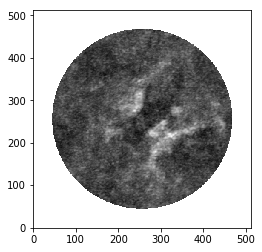

In [291]:
# Signal identification and noise estimation
peak_intensity_signal = cube_signal.max(axis=0) # Take the maximum along the spectral dimension

# Quick vizualization
imshow(peak_intensity_signal.value, cmap='gray', origin='lower')

In [292]:
# Make a low and high mask
low_snr_mask = (cube_signal > 3 * mad_std_map_sclip).include()
high_snr_mask = (cube_signal > 10 * mad_std_map_sclip).include()

# If using scipy.ndimage, UNCOMMENT BELOW.
# We need to convert from a dask array to a numpy array.
# This can be done by "computing" the mask (see text below for more details)

low_snr_mask = low_snr_mask.compute()
high_snr_mask = high_snr_mask.compute()

In [293]:
# With dask_image.ndmeasure:
# from dask_image import ndmeasure

# # Find connected structures
# structure = np.ones((3, 3, 3), dtype=bool)

# low_snr_mask_labels, num_labels = ndmeasure.label(low_snr_mask,
#                                                   structure=structure)

# # Ask dask to execute the operation
# num_labels = num_labels.compute()

# With scipy.ndimage:
import scipy.ndimage as nd

# Find connected structures
structure = np.ones((3, 3, 3), dtype=bool)

low_snr_mask_labels, num_labels = nd.label(low_snr_mask,
                                           structure=structure)

print(f"Initial number of regions found: {num_labels}")

Initial number of regions found: 4586


In [294]:
t0 = time.time()
# From the labels, count the number of pixels within each label.

# With dask_image.ndmeasure:
# num_pixels_in_high_snr_mask = ndmeasure.sum_labels(high_snr_mask,
#                                                    label_image=low_snr_mask_labels,
#                                                    index=range(1, num_labels + 1)) # +1 offset for mask labels

# # Repeat for the high signal mask.
# num_pixels_in_low_snr_mask = ndmeasure.sum_labels(low_snr_mask,
#                                                   label_image=low_snr_mask_labels,
#                                                   index=range(1, num_labels + 1)) # +1 offset for mask labels

# With scipy.ndimage:
import scipy.ndimage as nd

num_pixels_in_high_snr_mask = nd.sum(high_snr_mask,
                                     labels=low_snr_mask_labels,
                                     index=range(1, num_labels + 1)) # +1 offset for mask labels

# Repeat for the high signal mask.
num_pixels_in_low_snr_mask = nd.sum(low_snr_mask,
                                    labels=low_snr_mask_labels,
                                    index=range(1, num_labels + 1)) # +1 offset for mask labels

# To preserve the low_snr_mask, we will create a new signal mask where we will remove 
# regions that do not pass the criteria.
signal_mask = low_snr_mask

low_min_pixels = 40
high_min_pixels = 10

for num, (high_pix_num, low_pix_num) in enumerate(zip(num_pixels_in_high_snr_mask, num_pixels_in_low_snr_mask)):
    if high_pix_num >= high_min_pixels and low_pix_num >= low_min_pixels:
        # This region passes the criteria. Keep it in the mask.
        continue

    # Remove regions that do not pass the criteria.
    # NOTE: enumerate will start with 0, but the mask labels start at 1
    # We apply a +1 offset to `num` to account for this.
    signal_mask[low_snr_mask_labels == num + 1] = False
    
print(time.time() - t0)

9.414466619491577


In [295]:
# With dask_image.ndmeasure:
# signal_mask_labels, num_labels = ndmeasure.label(signal_mask,
#                                                   structure=structure)

# num_labels = num_labels.compute()

# With scipy.ndimage:
import scipy.ndimage
signal_mask_labels, num_labels = nd.label(signal_mask,
                                          structure=structure)

print(f"Final number of regions found: {num_labels}")

Final number of regions found: 20


In [296]:
# With dask_image:
# from dask_image import ndmorph
# from dask import array as da

# # Use a structure that will increase the mask size by 1 pixel in each direction.
# # Because we are applying it to the 3D cube, we need its size to be (3, 3, 3):

# # In the spatial dimension, expand by 1 pixel in each direction.
# # The structure looks like:
# # [1, 1, 1]
# # [1, 1, 1]
# # [1, 1, 1]
# structure = np.ones((3, 3), dtype=bool)

# # In the spectral dimension, only expand the original pixel along the spectral dimension.
# # The structure looks like:
# # [0, 0, 0]
# # [0, 1, 0]
# # [0, 0, 0]

# structure_spec = np.zeros((3, 3), dtype=bool)
# structure_spec[1, 1] = True

# # Add 1 spectral element on each side of the spatial structure.
# # np.dstack stacks the arrays along a new 3rd dimension:
# structure = np.dstack([structure_spec, structure, structure_spec])

# # Convert to a dask array
# structure = da.from_array(structure)

# signal_mask = ndmorph.binary_dilation(signal_mask, structure=structure, iterations=1)

# With scipy.ndimage:
import scipy.ndimage as nd

signal_mask = nd.binary_dilation(signal_mask, structure=structure, iterations=1)

# NOTE: Comment this line out if using scipy instead of dask-image!
# signal_mask = signal_mask.compute()

In [297]:
masked_cube = cube_signal.with_mask(signal_mask)

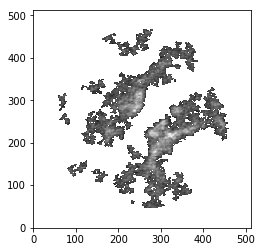

In [298]:
peak_intensity_sigmask = masked_cube.max(axis=0)

imshow(peak_intensity_sigmask.value, cmap='gray', origin='lower')

Text(0,0.5,'Brightness Temp. (K)')

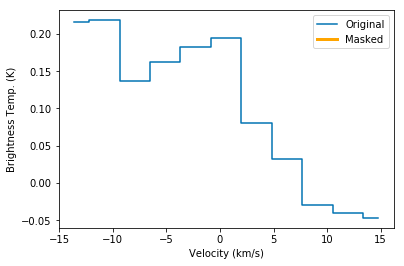

In [299]:
centre_spectrum = cube_signal[:, 256, 256]
centre_spectrum_sigmask = masked_cube[:, 256, 256]

plt.plot(centre_spectrum.spectral_axis.value,
         centre_spectrum.filled_data[:].value,
         drawstyle='steps-mid', label='Original')
plt.plot(centre_spectrum_sigmask.spectral_axis.value,
         centre_spectrum_sigmask.filled_data[:].value, drawstyle='steps-mid',
         linewidth=3, label='Masked', color='orange')

plt.legend(frameon=True)

plt.xlabel("Velocity (km/s)")
plt.ylabel('Brightness Temp. (K)')

#### Checking out and removing outliers

/blue/adamginsburg/abulatek/anaconda/lib/python3.7/site-packages/radio_beam-0.3.3-py3.7.egg/radio_beam/multiple_beams.py:265: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"


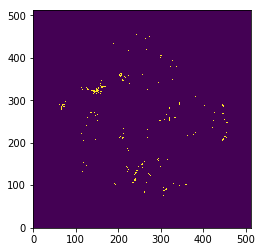

In [300]:
masked_moment1 = masked_cube.moment1()
masked_moment1_outliers = np.zeros(masked_moment1.shape)
masked_moment1_outliers[masked_moment1 > 15.*u.km/u.s] = True
masked_moment1_outliers[masked_moment1 < -15.*u.km/u.s] = True
imshow(masked_moment1_outliers, origin='lower')

In [301]:
# # Confirming that coordinate order is correct
# # This should yield 1:
# test_point = masked_moment1_outliers[indices[0][0], indices[1][0]]
# print(test_point)
# # This should yield 0:
# test_point = masked_moment1_outliers[indices[1][0], indices[0][0]]
# print(test_point)

In [302]:
indices = np.where(masked_moment1_outliers)
outlier_spectra = []
for n in range(len(indices[0])): # Loop over each of 1032 outliers
    y, x = indices[0][n], indices[1][n] # I think this is the correct order of coordinates
    outlier_spectra.append(masked_cube[:, y, x])

[ 14.77882498  11.93785843   9.09689188   6.25592533   3.41495878
   0.57399224  -2.26697431  -5.10794086  -7.94890741 -10.78987396
 -13.63084051] km / s
[        nan         nan  0.00552432  0.01424374 -0.01563061         nan
         nan         nan         nan         nan         nan] K


Text(0,0.5,'Brightness Temp. (K)')

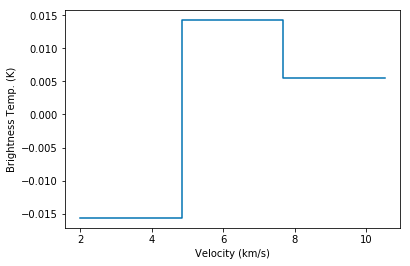

In [303]:
outlier_spectrum = outlier_spectra[1]
print(outlier_spectrum.spectral_axis)
print(outlier_spectrum.filled_data[:])
plt.plot(outlier_spectrum.spectral_axis.value,
         outlier_spectrum.filled_data[:].value,
         drawstyle='steps-mid')

plt.xlabel("Velocity (km/s)")
plt.ylabel('Brightness Temp. (K)')

### This cell is great!

/blue/adamginsburg/abulatek/anaconda/lib/python3.7/site-packages/radio_beam-0.3.3-py3.7.egg/radio_beam/multiple_beams.py:265: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"


Found 41518 previously unmasked outliers


/blue/adamginsburg/abulatek/anaconda/lib/python3.7/site-packages/radio_beam-0.3.3-py3.7.egg/radio_beam/multiple_beams.py:265: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"


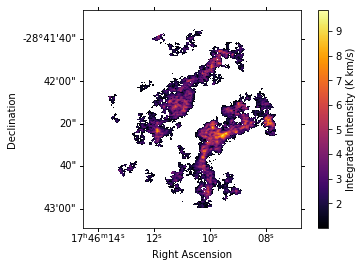

In [305]:
# width = masked_cube.spectral_axis[0] - masked_cube.spectral_axis[1]

# for n in range(len(indices[0])): # Loop over each of 1032 outliers
#     y, x = indices[0][n], indices[1][n] # I think this is the correct order of coordinates
#     signal_mask_no_outliers[:, y, x] = False # Remove outlier from signal mask

mom0 = masked_cube.moment0()
mom0_mask = mom0 > 1.*u.K*u.km/u.s # Mask pixels with mom0 less than threshold

# signal_mask_no_outliers = signal_mask & mom0_mask # Signal mask with mom0 threshold
# signal_mask_no_outliers &= mom0_mask # Could do if you already had signal_mask_no_outliers

# iter = 0
# for i in range(signal_mask_no_outliers.shape[1]): # Loop through each pixel in image
#     for j in range(signal_mask_no_outliers.shape[2]):
#         spectrum = signal_mask_no_outliers[:, i, j]
#         # There are no nans... why? Where did they come from? Where did they go?
#         mom0 = np.sum(spectrum)*u.K*width
#         if np.any(signal_mask[:, i, j] == True): # If the pixel hasn't already been totally masked
#             if mom0 < 6.*u.K*u.km/u.s: # What threshold should I use here? 1 = none, 10 = 10855
#                 iter += 1
#                 signal_mask_no_outliers[:, i, j] = False # Remove pixel from signal mask
print(f"Found {mom0_mask.sum()} good pixels")

masked_cube_no_outliers = masked_cube.with_mask(mom0_mask)

masked_moment0 = masked_cube_no_outliers.moment0()

ax = plt.subplot(projection=masked_moment0.wcs)
im = ax.imshow(masked_moment0.value, origin='lower', cmap='inferno')
cbar = plt.colorbar(im)
cbar.set_label('Integrated Intensity (K km/s)')

ax.set_ylabel('Declination')
ax.set_xlabel('Right Ascension')

#### Calculating moment maps

/blue/adamginsburg/abulatek/anaconda/lib/python3.7/site-packages/radio_beam-0.3.3-py3.7.egg/radio_beam/multiple_beams.py:265: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"


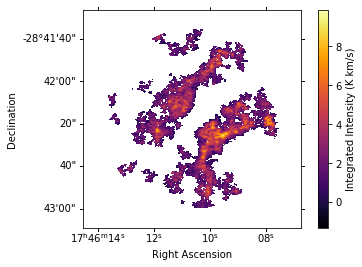

In [242]:
masked_moment0 = masked_cube.moment0()

ax = plt.subplot(projection=masked_moment0.wcs)
im = ax.imshow(masked_moment0.value, origin='lower', cmap='inferno')
cbar = plt.colorbar(im)
cbar.set_label('Integrated Intensity (K km/s)')

ax.set_ylabel('Declination')
ax.set_xlabel('Right Ascension')

/blue/adamginsburg/abulatek/anaconda/lib/python3.7/site-packages/radio_beam-0.3.3-py3.7.egg/radio_beam/multiple_beams.py:265: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"


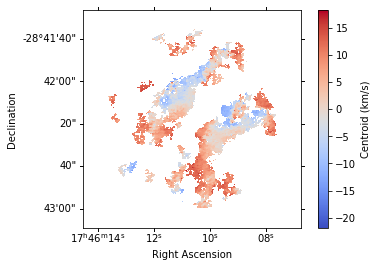

In [306]:
masked_moment1 = masked_cube_no_outliers.moment1()
# masked_moment1[masked_moment1 > 25.*u.km/u.s] = np.nan
# masked_moment1[masked_moment1 < -25.*u.km/u.s] = np.nan

ax = plt.subplot(projection=masked_moment1.wcs)
im = ax.imshow(masked_moment1.value, origin='lower', cmap='coolwarm')
cbar = plt.colorbar(im)
cbar.set_label('Centroid (km/s)')

ax.set_ylabel('Declination')
ax.set_xlabel('Right Ascension')

/blue/adamginsburg/abulatek/anaconda/lib/python3.7/site-packages/radio_beam-0.3.3-py3.7.egg/radio_beam/multiple_beams.py:265: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"


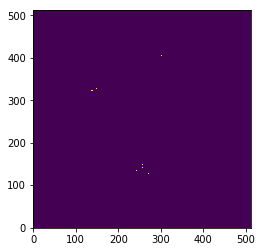

In [307]:
masked_moment1 = masked_cube_no_outliers.moment1()
masked_moment1_outliers = (masked_moment1 > 15.*u.km/u.s) | (masked_moment1 < -15.*u.km/u.s)
imshow(masked_moment1_outliers, origin='lower') 
# Clumps of outliers might mean they're real, just outside of vel range

In [252]:
np.array(np.where(masked_moment1_outliers)).T

array([[ 56, 234],
       [ 56, 256],
       [ 58, 233],
       ...,
       [449, 274],
       [454, 243],
       [464, 275]])

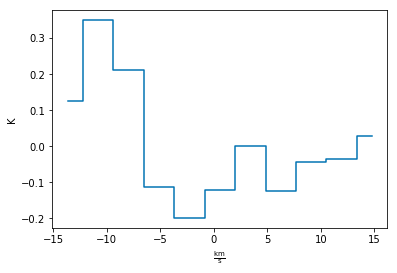

In [318]:
worst = np.unravel_index(np.nanargmin(masked_moment1), masked_moment1.shape) # Worst positive outlier
spectrum = cube_signal[:, worst[0], worst[1]]
spectrum.quicklook()

In [317]:
cube_signal, masked_cube

(DaskVaryingResolutionSpectralCube with shape=(11, 512, 512) and unit=K and chunk size (11, 256, 256):
  n_x:    512  type_x: RA---SIN  unit_x: deg    range:   266.528130 deg:  266.560501 deg
  n_y:    512  type_y: DEC--SIN  unit_y: deg    range:   -28.719152 deg:  -28.690763 deg
  n_s:     11  type_s: VRAD      unit_s: km / s  range:      -13.631 km / s:      14.779 km / s,
 DaskVaryingResolutionSpectralCube with shape=(11, 512, 512) and unit=K and chunk size (11, 256, 256):
  n_x:    512  type_x: RA---SIN  unit_x: deg    range:   266.528130 deg:  266.560501 deg
  n_y:    512  type_y: DEC--SIN  unit_y: deg    range:   -28.719152 deg:  -28.690763 deg
  n_s:     11  type_s: VRAD      unit_s: km / s  range:      -13.631 km / s:      14.779 km / s)

In [ ]:
# unmasked_moment1 = cube_signal.moment1()

# ax = plt.subplot(projection=unmasked_moment1.wcs)
# im = ax.imshow(unmasked_moment1.value, origin='lower', cmap='coolwarm')
# cbar = plt.colorbar(im)
# cbar.set_label('Centroid (km/s)')

# ax.set_ylabel('Declination')
# ax.set_xlabel('Right Ascension')

In [ ]:
# masked_moment2 = masked_cube.moment2()

In [ ]:
# masked_linewidth = masked_cube.linewidth_sigma()

# ax = plt.subplot(projection=masked_linewidth.wcs)
# im = ax.imshow(masked_linewidth.value, origin='lower', cmap='coolwarm')
# cbar = plt.colorbar(im)
# cbar.set_label('Line Width (km/s)')

# ax.set_ylabel('Declination')
# ax.set_xlabel('Right Ascension')

In [ ]:
# masked_fwhm = masked_cube.linewidth_fwhm()

In [ ]:
# unmasked_linewidth = cube_signal.linewidth_sigma()

# ax = plt.subplot(projection=unmasked_linewidth.wcs)
# im = ax.imshow(unmasked_linewidth.value, origin='lower', cmap='coolwarm')
# cbar = plt.colorbar(im)
# cbar.set_label('Line Width (km/s)')

# ax.set_ylabel('Declination')
# ax.set_xlabel('Right Ascension')

### H13CO+

In [ ]:
h13cop = get_moment_0(cube_87_spw25, 'H13CO+', 86.7*u.GHz, 86.78*u.GHz, 66.5)
h13cop.quicklook()

### HN13C

In [ ]:
hn13c = get_moment_0(cube_87_spw25, 'HN13C', 87.06*u.GHz, 87.11*u.GHz, 12.)
hn13c.quicklook()

### CCH v=0

In [ ]:
cchv0 = get_moment_0(cube_87_spw25, ' CCH', 87.25*u.GHz, 87.35*u.GHz, 12.)
cchv0.quicklook()

### CH3CCH

In [ ]:
ch3cch = get_moment_0(cube_102_spw106, 'CH3CCH', 102.5*u.GHz, 102.56*u.GHz, 0.)
ch3cch.quicklook()

### N2H+ (not good)

In [ ]:
n2hp = cube_95_spw25.spectral_slab(93.15*u.GHz, 93.18*u.GHz).with_spectral_unit(u.km/u.s,
                                                                       rest_value=93.1737*u.GHz,
                                                                       velocity_convention='radio').moment0()
n2hp.quicklook()

# n2hp = get_moment_0(cube_95_spw25, 'N2H+', 93.15*u.GHz, 93.18*u.GHz, 0.)
# n2hp.quicklook()

### SiO v=1 (maser)

In [ ]:
cube = cube_87_spw25
freq = 86.233127*u.GHz # Center frequency
slab_width = 2*u.km/u.s

subcube = cube.with_spectral_unit(u.km/u.s, 
                                  rest_value = freq,
                                  velocity_convention = 'radio')
subcube_v = subcube.spectral_slab(-0.5*slab_width, 0.5*slab_width).to(u.K)
moment_0 = subcube_v.moment(order = 0)
plt.gca().set_xticks([]); plt.gca().set_yticks([])
moment_0.quicklook('SiOv=1_1.png')

In [ ]:
cube = cube_87_spw25
freq = 86.238985*u.GHz # Center frequency
slab_width = 2*u.km/u.s

subcube = cube.with_spectral_unit(u.km/u.s, 
                                  rest_value = freq,
                                  velocity_convention = 'radio')
subcube_v = subcube.spectral_slab(-0.5*slab_width, 0.5*slab_width).to(u.K)
moment_0 = subcube_v.moment(order = 0)
plt.gca().set_xticks([]); plt.gca().set_yticks([])
moment_0.quicklook('SiOv=1_2.png')

### CH3OH Class I (maser)

In [ ]:
cube = cube_95_spw25
freq = 95.156*u.GHz # Center frequency
slab_width = 2*u.km/u.s

subcube = cube.with_spectral_unit(u.km/u.s, 
                                  rest_value = freq,
                                  velocity_convention = 'radio')
subcube_v = subcube.spectral_slab(-0.5*slab_width, 0.5*slab_width).to(u.K)
moment_0 = subcube_v.moment(order = 0)
plt.gca().set_xticks([]); plt.gca().set_yticks([])
moment_0.quicklook('methanol.png')